Qualitative Analysis
1. Annotation - Identify patterns in misclassified text
2. Frequency analysis - Frequency distribution of prediction probability; Determine high probability and low probability thresholds
3. PCA analysis - Type 1 and Type 2 error PCA (annotation as features)

1. Annotation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm

In [8]:
# import misclassified text with annotated labels
anno = pd.read_csv('data/misclassified_annotation.csv')
anno.head()

,Unnamed: 0,question,responses,actual_label,pred_label,pred_probability,Sensi_cont,emoji_char,spchar_noeng,neg_notion,incomp_sent,named_entity,profanity,rhetoric,subjectivity,coherence
0,2530,Would my dead body decompose if sent into spac...,Solar radiation would likely pick you apart sl...,Real,Fake,0.502060,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0
1,3805,why diffrent alcohols effect me . I can drink ...,* different * affect * just rewrite that sentence,Real,Fake,0.506464,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,1990,What happens to someone in a wheelchair when t...,How do the other prisoners treat them ?,Real,Fake,0.506785,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
3,2125,Why does store bought orange juice ( e.g. Trop...,"pasteurization , poor quality fruit , and unme...",Real,Fake,0.508209,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1.0
4,1874,How does my ISP ( Suddenlink ) know when I 've...,They recieved a letter from the studio that cl...,Real,Fake,0.509648,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0


In [9]:
# initial cleaning
anno.rename(columns={"Unnamed: 0" :'id'}, inplace=True )
anno.columns = anno.columns.str.lower()

# combine sensitive_content with neg_notion
anno['sensi_cont'] = np.where((anno['sensi_cont'] == 1)|(anno['neg_notion'] == 1),1,0)
anno.drop(columns=['neg_notion'],inplace=True)

# creat column to determine if the input text length is short (here we define short as shorter than the average misclassified text)
def get_tokens(col):
     col_token = nltk.word_tokenize(col)
     return len(col_token)
anno['short_text'] = anno['responses'].apply(get_tokens)
anno['short_text'] = np.where(anno['short_text']<=anno['short_text'].mean(),1,0)

# create column to categorize false positive and false negative
anno['type1'] = np.where(((anno['actual_label']=="Fake")&(anno['pred_label'] == "Real")), 1, 0)
anno['type2'] = np.where(((anno['actual_label']=='Real')&(anno['pred_label']=='Fake')),1,0)
# fill na with 0
anno.iloc[:,6:] = anno.iloc[:,6:].fillna(value=0)
anno.head()

,id,question,responses,actual_label,pred_label,pred_probability,sensi_cont,emoji_char,spchar_noeng,incomp_sent,named_entity,profanity,rhetoric,subjectivity,coherence,short_text,type1,type2
0,2530,Would my dead body decompose if sent into spac...,Solar radiation would likely pick you apart sl...,Real,Fake,0.502060,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,1
1,3805,why diffrent alcohols effect me . I can drink ...,* different * affect * just rewrite that sentence,Real,Fake,0.506464,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,1
2,1990,What happens to someone in a wheelchair when t...,How do the other prisoners treat them ?,Real,Fake,0.506785,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,1
3,2125,Why does store bought orange juice ( e.g. Trop...,"pasteurization , poor quality fruit , and unme...",Real,Fake,0.508209,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1,0,1
4,1874,How does my ISP ( Suddenlink ) know when I 've...,They recieved a letter from the studio that cl...,Real,Fake,0.509648,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,1


2. Fequency Analysis

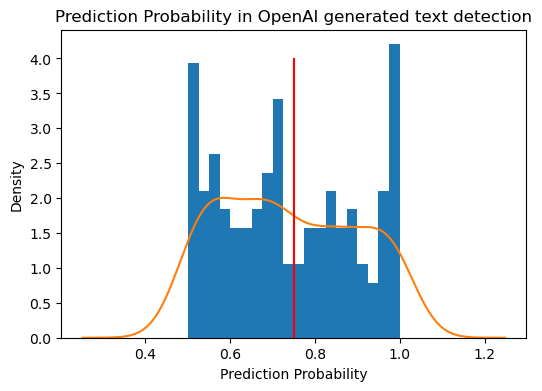

In [82]:
fig, ax = plt.subplots(figsize = (6,4))

# Plots #
    # Plot histogram
anno['pred_probability'].plot(kind = "hist", density = True, bins = 20) # change density to true, because KDE uses density
    # Plot KDE
anno['pred_probability'].plot(kind = "kde")

# X #
ax.set_xlabel("Prediction Probability")
plt.vlines(x=0.75,ymin=0,ymax=4,colors='red')

# Overall #
ax.set_title("Prediction Probability in OpenAI generated text detection")

plt.show()

Looks like the cutoff is around 0.8 but blow 0.8
Elbow method to determine cuttoff at 0.75

{'whiskers': [<matplotlib.lines.Line2D at 0x2c4c5fb0460>,
 'caps': [<matplotlib.lines.Line2D at 0x2c4c8989790>,
 'boxes': [<matplotlib.lines.Line2D at 0x2c4c5fb0280>],
 'medians': [<matplotlib.lines.Line2D at 0x2c4c89891c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2c4c8980670>],
 'means': [<matplotlib.lines.Line2D at 0x2c4c8989370>]}

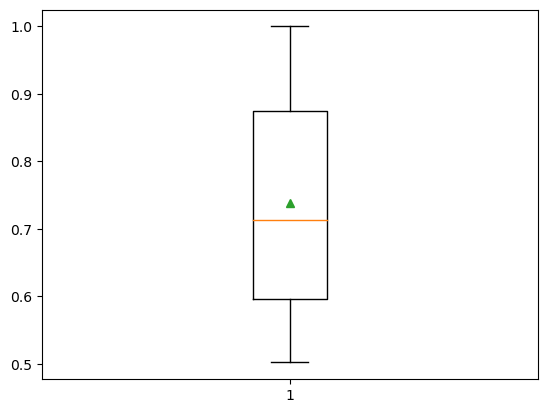

In [83]:
plt.boxplot(anno['pred_probability'],showmeans=True)

What are they getting wrong?
- High probability errors (pred_probability > 0.75)
- Low probability errors (pred_probability <= 0.75)

In [84]:
low_prob = anno.loc[anno['pred_probability']<=0.75]
high_prob = anno.loc[anno['pred_probability']>0.75]

print("There are {} observations in the low probability group and {} observations in the high probability group".format(low_prob.shape[0],high_prob.shape[0]))

There are 85 observations in the low probability group and 68 observations in the high probability group


In [85]:
low_prob.describe()

,id,pred_probability,sensi_cont,emoji_char,spchar_noeng,incomp_sent,named_entity,profanity,rhetoric,subjectivity,coherence,short_text,type1,type2
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000
mean,2195.541176,0.614747,0.247059,0.011765,0.188235,0.094118,0.294118,0.047059,0.176471,0.376471,0.647059,0.741176,0.082353,0.917647
std,1202.570685,0.075823,0.433861,0.108465,0.393220,0.293725,0.458349,0.213021,0.383482,0.487376,0.480721,0.440588,0.276533,0.276533
min,4.000000,0.502060,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1106.000000,0.547247,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2232.000000,0.607411,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
75%,3331.000000,0.685160,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,3954.000000,0.744573,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [86]:
high_prob.describe()

,id,pred_probability,sensi_cont,emoji_char,spchar_noeng,incomp_sent,named_entity,profanity,rhetoric,subjectivity,coherence,short_text,type1,type2
count,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000
mean,2045.867647,0.893825,0.117647,0.014706,0.352941,0.117647,0.250000,0.073529,0.191176,0.264706,0.838235,0.632353,0.323529,0.676471
std,1217.803417,0.077400,0.324585,0.121268,0.481438,0.324585,0.436232,0.262944,0.396151,0.444457,0.370973,0.485750,0.471301,0.471301
min,13.000000,0.751242,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,785.000000,0.828247,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,2274.500000,0.892526,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
75%,2961.250000,0.970591,0.000000,0.000000,1.000000,0.000000,0.250000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,3995.000000,0.999803,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


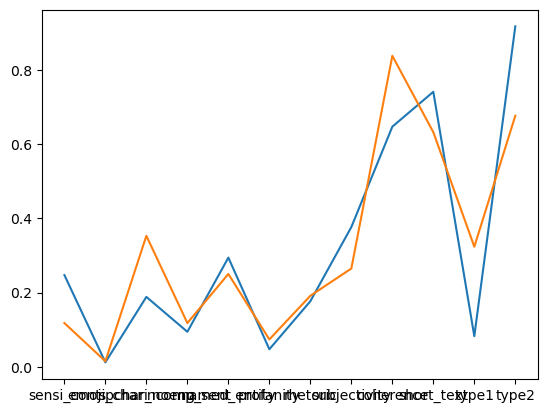

In [87]:
plt.plot(low_prob.iloc[:,6:].mean())
plt.plot(high_prob.iloc[:,6:].mean())

PCA Analysis 
1. Analyze the features in low end and high end probabilities
2. Analyze the features in type1 and type2 errors

1. What are the expressive features in the two ends of probabilities
- 1.a. Low end of prediction probability

In [88]:
low_prob_pca = low_prob.iloc[:,6:-2]


pca = PCA(n_components = 10)
x_low_pca = pca.fit_transform(low_prob_pca)

print(x_low_pca,x_low_pca.shape)

[[-3.82304878e-01 -8.33025550e-01  5.14822111e-02  2.80182277e-01
   1.70493524e-02  2.92984144e-01 -2.35645156e-01 -1.32877117e-02
  -3.77000540e-02 -5.21323153e-04]
 [ 2.14581283e-01  3.51406824e-01 -6.96398390e-01 -3.11642276e-01
  -3.76015194e-03  1.07636880e+00  6.01642589e-01 -1.22448433e-01
   2.53904420e-02 -1.44270754e-02]
 [ 5.21065168e-01 -5.14735793e-01 -2.76101410e-01  7.52356775e-01
   8.21743134e-01  2.54682240e-01 -8.04121585e-02 -2.76631683e-01
   6.18385751e-02 -3.92722400e-04]
 [-4.27342883e-01 -8.94659549e-01  1.08064725e-01  9.36942746e-02
   7.31539241e-02  6.43320673e-01  6.71756561e-01  3.32706138e-02
   2.82536580e-02  1.98408820e-02]
 [-9.52885562e-01  1.05472157e+00  6.78698447e-02  1.04133051e-02
   6.46977266e-02  1.49490749e-01 -1.47359574e-01  4.68141290e-02
   1.87914409e-02  1.80813403e-02]
 [ 1.62434472e-01 -7.42075997e-01  6.71490565e-01 -6.12807989e-02
  -4.79869559e-02  1.82843412e-01 -2.91475612e-01  3.96590019e-01
   4.27431414e-02 -6.10918968e-03

In [89]:
feature_names = low_prob_pca.columns.to_list()
feature_names

['sensi_cont',
 'emoji_char',
 'spchar_noeng',
 'incomp_sent',
 'named_entity',
 'profanity',
 'rhetoric',
 'subjectivity',
 'coherence',
 'short_text']

In [90]:
pca.explained_variance_ratio_


array([0.26676187, 0.17932328, 0.14565286, 0.11869494, 0.0917926 ,
       0.08085333, 0.04986919, 0.03296835, 0.02671449, 0.00736909])

In [91]:
pca.explained_variance_ratio_
# Check loadings by each column used for PCA
loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns=[f'PC{i}' for i in range(1, len(pca.explained_variance_ratio_) + 1)],
    index=feature_names
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
sensi_cont,-0.062113,-0.244899,0.231310,0.165971,0.109219,0.166819,-0.053579,-0.013238,0.023345,0.001732
emoji_char,0.017977,-0.000343,0.002055,-0.010730,-0.008096,-0.000586,-0.005089,-0.010910,-0.009416,0.104988
spchar_noeng,-0.078889,0.269353,-0.098093,-0.046885,0.039485,0.220336,-0.072077,0.088272,0.030408,0.002852
incomp_sent,-0.028548,-0.032031,0.026502,-0.078850,0.020861,0.122256,0.248686,0.010375,0.013230,0.002145
named_entity,-0.101106,0.289583,0.175733,0.261795,-0.109857,-0.039458,0.054138,-0.001998,-0.004672,0.001530
profanity,-0.001782,-0.015086,-0.028421,-0.002825,-0.066255,-0.038302,-0.002551,-0.033691,0.193185,0.003565
rhetoric,0.148946,0.032085,-0.106043,0.158170,0.258071,-0.110969,0.043261,0.077528,0.027604,0.004743
subjectivity,0.345292,0.047267,0.290398,-0.144376,-0.024182,-0.038436,-0.015301,0.091335,0.016136,-0.000589
coherence,-0.423670,-0.133331,0.047389,-0.041473,-0.041135,-0.097603,0.000718,0.136210,0.007637,0.004730
short_text,0.243790,-0.177231,-0.161345,0.163002,-0.197307,0.064133,0.011444,0.086120,-0.008941,0.000690


In [92]:
pca9_np1=np.reshape(pca.components_[0,:],(10,1))
pca9_np2=np.reshape(pca.components_[1,:],(10,1))
pca9_np3=np.reshape(pca.components_[2,:],(10,1))

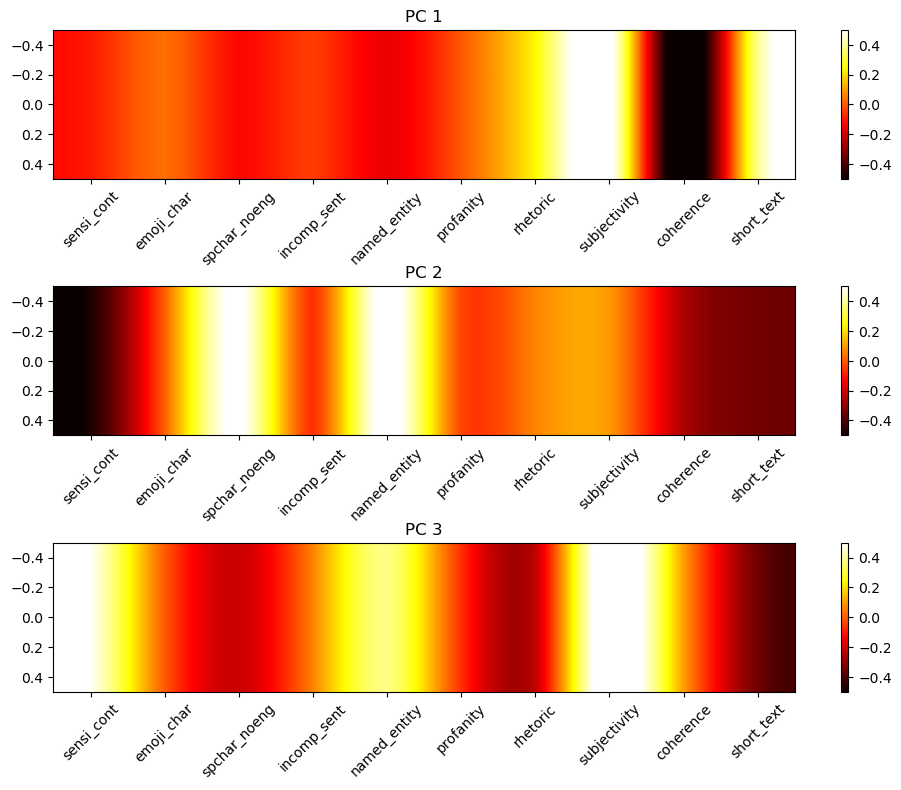

In [93]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, figsize=(10,9))
# fig.tight_layout(h_pad=2)

im=ax1.imshow(np.transpose(pca9_np1),vmin=-0.5,vmax=0.5, aspect='auto',cmap=cm.hot,interpolation='spline16')
ax1.set_title('PC 1')
fig.colorbar(im, ax=ax1)
ax1.set_xticks(np.arange(0,10,1))
ax1.set_xticklabels(feature_names,rotation=45)

im2=ax2.imshow(np.transpose(pca9_np2),vmin=-0.5,vmax=0.5, aspect='auto',cmap=cm.hot,interpolation='spline16')
ax2.set_title('PC 2')
fig.colorbar(im2, ax=ax2)
ax2.set_xticks(np.arange(0,10,1))
ax2.set_xticklabels(feature_names,rotation=45)

im3=ax3.imshow(np.transpose(pca9_np3),vmin=-0.5,vmax=0.5, aspect='auto',cmap=cm.hot,interpolation='spline16')
ax3.set_title('PC 3')
fig.colorbar(im3, ax=ax3)
ax3.set_xticks(np.arange(0,10,1))
ax3.set_xticklabels(feature_names,rotation=45)
fig.tight_layout()
plt.subplots_adjust(top=0.85)

- 1.b High end of prediction probability

In [112]:
high_prob_pca = high_prob.iloc[:,6:-2]


pca2 = PCA(n_components = 10)
x_high_pca = pca2.fit_transform(high_prob_pca)

print(x_high_pca,x_high_pca.shape)

[[ 9.49941971e-02 -4.09620047e-01  1.03555528e-01  1.74651324e-02
  -4.88813305e-01  1.55810395e-01 -9.22005662e-02 -3.76649920e-01
   8.59526622e-01 -3.24695286e-02]
 [ 9.93016964e-01  7.45905337e-01 -5.53663646e-01  4.31739750e-01
   1.50027648e-01  5.57136862e-02 -7.23307138e-02 -2.54395593e-01
  -4.65938005e-02 -4.74169996e-02]
 [-3.39544091e-01 -2.41876562e-01 -8.95158082e-01  4.79462632e-01
   1.73246853e-01  1.61071252e-01 -3.00493466e-02  8.21220200e-02
  -9.88567237e-02 -6.38319356e-02]
 [ 1.97536668e-01 -4.33420688e-01  1.05979483e-01  9.48417625e-02
  -3.26293316e-01 -2.85431756e-01 -2.15750549e-01 -2.95038214e-02
   6.83006551e-02 -3.46206692e-02]
 [ 1.95493117e-01 -1.36972023e-01 -2.06183654e-02  8.66543251e-01
  -3.89537166e-01  7.46892249e-01 -2.57619949e-01  2.15362427e-01
  -3.40390521e-01 -8.07744346e-02]
 [ 1.00186057e+00  4.83587125e-01 -1.49978800e-01 -3.58823018e-01
   6.65129151e-03 -1.78849084e-01 -3.05605593e-01 -3.47387703e-01
  -1.68112892e-02  1.28476480e-02

In [113]:
pca2.explained_variance_ratio_


array([0.22923837, 0.15803004, 0.15468279, 0.137525  , 0.10835962,
       0.07220225, 0.0564054 , 0.03897847, 0.03523062, 0.00934743])

In [114]:
# Check loadings by each column used for PCA
loadings2 = pd.DataFrame(
    data=pca2.components_.T * np.sqrt(pca2.explained_variance_), 
    columns=[f'PC{i}' for i in range(1, len(pca2.explained_variance_ratio_) + 1)],
    index=feature_names
)
loadings2

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
sensi_cont,0.003913,0.016308,0.130986,-0.008407,-0.081751,0.257653,-0.078543,0.036040,-0.085483,0.001640
emoji_char,0.005125,-0.005719,-0.010072,0.032056,-0.007627,-0.002743,0.001122,0.005433,0.003606,0.115795
spchar_noeng,-0.303990,-0.033817,-0.282431,-0.180943,0.140919,0.068450,-0.013580,0.004422,-0.030992,0.003609
incomp_sent,0.119164,-0.062182,-0.029288,-0.125262,-0.073403,0.047935,0.241768,0.060183,-0.031312,0.000730
named_entity,-0.005089,0.125339,-0.190832,0.352382,0.056728,0.075757,0.066591,0.022067,-0.006719,-0.007003
profanity,-0.059011,0.011372,-0.001146,-0.034490,-0.064302,0.142508,0.035269,-0.082378,0.178504,0.000250
rhetoric,0.055839,-0.071474,0.193011,0.007891,0.319156,0.048682,0.025931,0.065408,0.047016,0.001353
subjectivity,0.190896,0.347619,-0.082856,-0.141204,0.008943,-0.003997,-0.047607,0.094892,0.045704,0.001562
coherence,-0.271977,-0.090538,0.038142,0.061011,-0.122790,-0.038420,-0.021956,0.170326,0.064905,-0.003954
short_text,0.327853,-0.270206,-0.208791,0.008103,-0.013684,0.032003,-0.087077,0.042131,0.034858,-0.003233


In [115]:
pca2_np1=np.reshape(pca2.components_[0,:],(10,1))
pca2_np2=np.reshape(pca2.components_[1,:],(10,1))
pca2_np3=np.reshape(pca2.components_[2,:],(10,1))

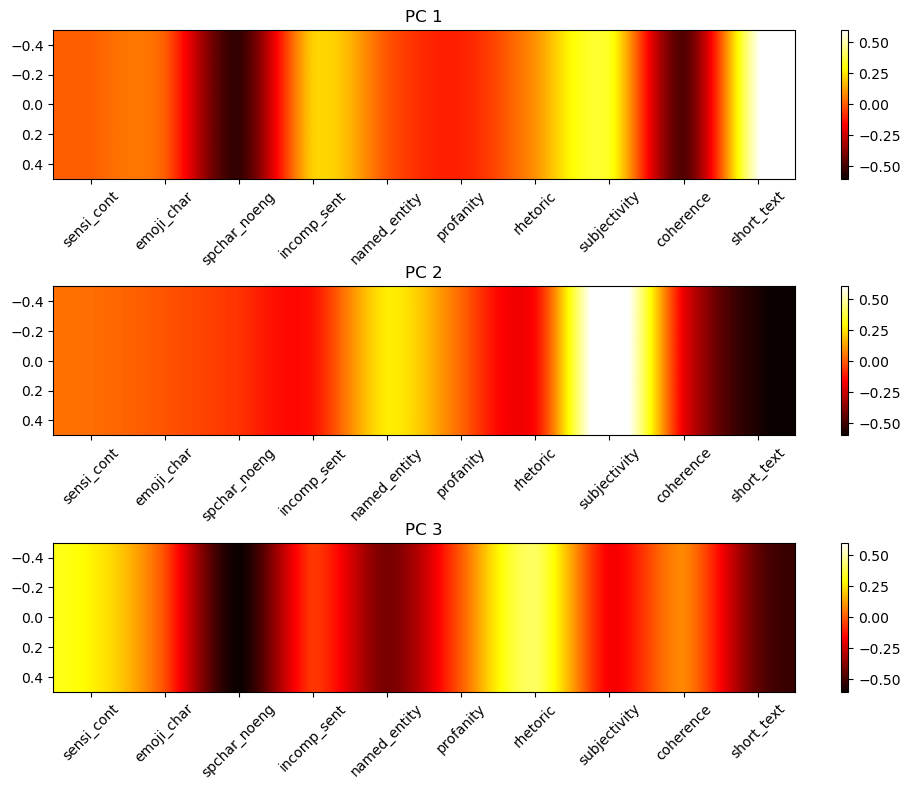

In [116]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, figsize=(10,9))
# fig.tight_layout(h_pad=2)

im=ax1.imshow(np.transpose(pca2_np1),vmin=-0.6,vmax=0.6, aspect='auto',cmap=cm.hot,interpolation='spline16')
ax1.set_title('PC 1')
fig.colorbar(im, ax=ax1)
ax1.set_xticks(np.arange(0,10,1))
ax1.set_xticklabels(feature_names,rotation=45)

im2=ax2.imshow(np.transpose(pca2_np2),vmin=-0.6,vmax=0.6, aspect='auto',cmap=cm.hot,interpolation='spline16')
ax2.set_title('PC 2')
fig.colorbar(im2, ax=ax2)
ax2.set_xticks(np.arange(0,10,1))
ax2.set_xticklabels(feature_names,rotation=45)

im3=ax3.imshow(np.transpose(pca2_np3),vmin=-0.6,vmax=0.6, aspect='auto',cmap=cm.hot,interpolation='spline16')
ax3.set_title('PC 3')
fig.colorbar(im3, ax=ax3)
ax3.set_xticks(np.arange(0,10,1))
ax3.set_xticklabels(feature_names,rotation=45)
fig.tight_layout()
plt.subplots_adjust(top=0.85)

2. What are the expressive features in Type 1 Errors and Type 2 Errors
- 2.a Type 1 Errors

In [117]:
# Seperate the two dfs
type1 = anno.loc[anno['type1'] == 1]
type2 = anno.loc[anno['type2'] == 1]

type1_pca = type1.iloc[:,6:-2]
type2_pca = type2.iloc[:,6:-2]


In [118]:

pca3 = PCA(n_components = 10)
x_type1_pca = pca3.fit_transform(type1_pca)

print(x_type1_pca,x_type1_pca.shape)

[[ 2.84780079e-01  4.12820928e-01 -2.17448806e-01 -6.96671139e-01
  -8.63652628e-02 -4.51245811e-01 -2.31211397e-01 -3.35662951e-16
  -7.45413832e-03  6.34917953e-17]
 [ 1.24806668e+00  4.13012081e-01 -4.95995444e-01 -1.02009133e-01
  -3.00947414e-01  2.08275912e-01  1.60201973e-01 -6.30976072e-17
  -8.89950785e-02  2.07221232e-16]
 [-1.35218791e-01 -6.60474130e-01 -1.22008920e-01 -6.70928794e-02
   9.33428309e-01 -3.07736817e-01  2.09034844e-01  5.53536688e-16
  -1.15946530e-01  2.96711820e-17]
 [ 7.49189511e-02  8.87048069e-01 -6.39366872e-01  3.41370159e-01
  -5.15326589e-01 -1.50953055e-01  1.88166250e-01 -2.61395158e-16
  -1.67019688e-01 -5.64685336e-17]
 [ 4.83376693e-01 -3.08712293e-01 -5.43865564e-01 -8.86959205e-01
   2.68900527e-02  5.78886233e-01  2.34688769e-01  2.12743536e-16
   7.08401137e-02 -4.61133474e-17]
 [-3.41277660e-01  8.89590619e-01 -3.05108754e-01 -3.17555433e-01
  -1.78626397e-01 -1.57340903e-02 -9.10989535e-02 -1.67826834e-16
   9.98552819e-02 -1.43476617e-17

In [119]:
pca3.explained_variance_ratio_

array([2.53058235e-01, 2.11905284e-01, 1.66013013e-01, 1.27931755e-01,
       9.42863561e-02, 6.50488114e-02, 4.64191104e-02, 2.52613240e-02,
       1.00761107e-02, 1.71450338e-33])

In [120]:
loadings3 = pd.DataFrame(
    data=pca3.components_.T * np.sqrt(pca3.explained_variance_), 
    columns=[f'PC{i}' for i in range(1, len(pca3.explained_variance_ratio_) + 1)],
    index=feature_names
)
loadings3

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
sensi_cont,0.327237,1.496288e-03,2.699036e-02,-2.733047e-02,4.458586e-02,2.410117e-01,2.872986e-02,9.201816e-18,2.212048e-02,-5.081780e-33
emoji_char,0.000000,-5.696988e-18,2.521248e-17,-3.504338e-17,-3.546791e-17,1.683421e-17,2.488626e-17,6.952784e-17,3.644033e-17,4.923366e-17
spchar_noeng,-0.374470,2.609591e-01,-4.246833e-02,1.612330e-01,-3.368497e-02,1.320725e-01,3.589368e-02,2.203758e-17,1.280788e-02,-1.093207e-32
incomp_sent,0.016524,-5.747554e-02,-3.541058e-02,4.372671e-02,-3.432924e-02,-4.681714e-02,1.787636e-02,1.336306e-01,7.869745e-02,-1.810624e-32
named_entity,0.061826,2.527984e-01,-2.551105e-01,-2.473692e-01,-6.389642e-02,-3.272724e-02,8.796123e-02,6.369251e-17,1.788851e-03,-2.733017e-33
profanity,0.019055,6.175846e-02,-2.374463e-02,7.397887e-02,3.116708e-01,-6.059132e-02,1.101191e-01,4.300120e-16,1.615475e-03,1.024881e-33
rhetoric,-0.017456,-2.130636e-03,3.217560e-01,-4.727308e-02,-1.071352e-01,-2.307547e-02,1.722787e-01,3.548686e-16,-4.687519e-03,3.330864e-33
subjectivity,0.248944,-1.391660e-03,-1.619370e-01,2.802325e-01,-1.229308e-01,-4.100627e-02,7.154152e-02,1.596287e-16,-3.185277e-02,-5.466034e-33
coherence,-0.016524,5.747554e-02,3.541058e-02,-4.372671e-02,3.432924e-02,4.681714e-02,-1.787636e-02,1.336306e-01,-7.869745e-02,-1.059044e-32
short_text,-0.208448,-3.964263e-01,-1.851284e-01,-5.359657e-02,-3.235822e-03,7.138437e-02,9.062338e-02,2.013264e-16,-1.277570e-02,-0.000000e+00


In [121]:
pca3_np1=np.reshape(pca3.components_[0,:],(10,1))
pca3_np2=np.reshape(pca3.components_[1,:],(10,1))
pca3_np3=np.reshape(pca3.components_[2,:],(10,1))

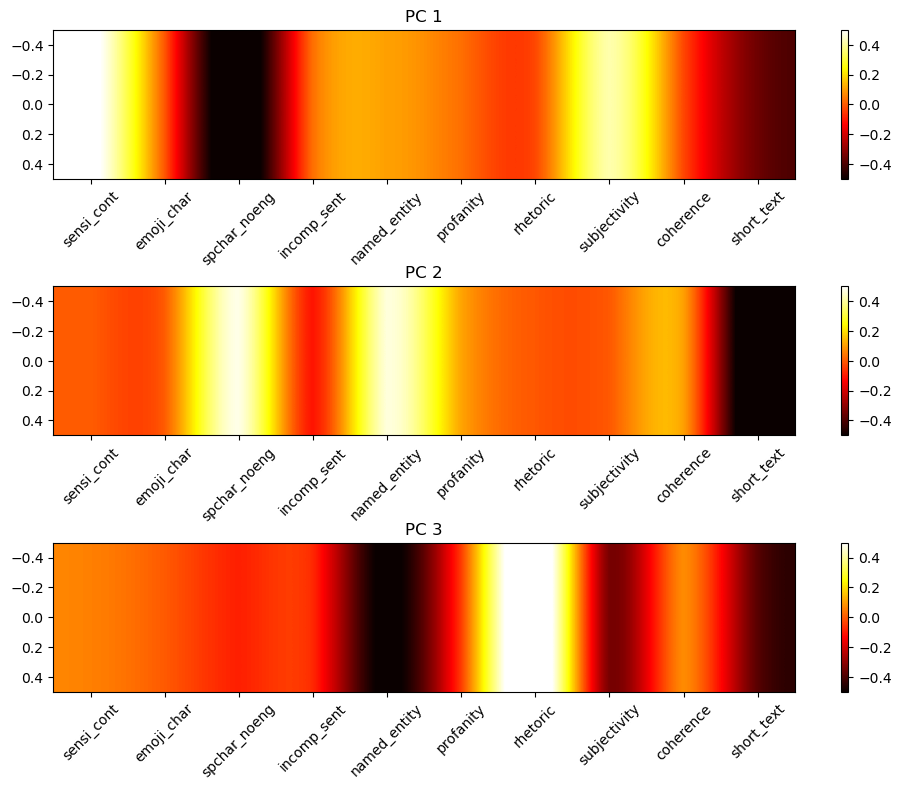

In [122]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, figsize=(10,9))
# fig.tight_layout(h_pad=2)

im=ax1.imshow(np.transpose(pca3_np1),vmin=-0.5,vmax=0.5, aspect='auto',cmap=cm.hot,interpolation='spline16')
ax1.set_title('PC 1')
fig.colorbar(im, ax=ax1)
ax1.set_xticks(np.arange(0,10,1))
ax1.set_xticklabels(feature_names,rotation=45)

im2=ax2.imshow(np.transpose(pca3_np2),vmin=-0.5,vmax=0.5, aspect='auto',cmap=cm.hot,interpolation='spline16')
ax2.set_title('PC 2')
fig.colorbar(im2, ax=ax2)
ax2.set_xticks(np.arange(0,10,1))
ax2.set_xticklabels(feature_names,rotation=45)

im3=ax3.imshow(np.transpose(pca3_np3),vmin=-0.5,vmax=0.5, aspect='auto',cmap=cm.hot,interpolation='spline16')
ax3.set_title('PC 3')
fig.colorbar(im3, ax=ax3)
ax3.set_xticks(np.arange(0,10,1))
ax3.set_xticklabels(feature_names,rotation=45)
fig.tight_layout()
plt.subplots_adjust(top=0.85)

-2.b Type2 Errors

In [123]:
pca4 = PCA(n_components = 10)
x_type2_pca = pca4.fit_transform(type2_pca)

print(x_type2_pca,x_type2_pca.shape)

[[-0.36014436 -0.77274021  0.06908114 ... -0.08020998 -0.07590736
  -0.00840166]
 [ 0.17311228  0.07667035 -0.01675138 ... -0.30529967 -0.08601576
  -0.00496784]
 [ 0.54918942 -0.70465873  0.62656624 ... -0.29996815  0.01776016
   0.01502025]
 ...
 [-0.25566494  0.71421875 -0.94409233 ...  0.34555139  0.01095257
   0.02166628]
 [-0.29681676  1.33032173 -0.44320603 ...  0.36989856  0.0203972
   0.00198635]
 [-0.35225269  0.22806298  0.57665928 ... -0.01745388 -0.12584407
   0.94211308]] (124, 10)


In [124]:
pca4.explained_variance_ratio_

array([0.25655795, 0.16241138, 0.13061841, 0.12250191, 0.09991308,
       0.08658099, 0.06329283, 0.04230698, 0.02533951, 0.01047696])

In [125]:
loadings4 = pd.DataFrame(
    data=pca4.components_.T * np.sqrt(pca4.explained_variance_), 
    columns=[f'PC{i}' for i in range(1, len(pca4.explained_variance_ratio_) + 1)],
    index=feature_names
)
loadings4

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
sensi_cont,-0.022265,-0.184365,0.001152,-0.191181,-0.016708,0.275584,-0.068672,-0.017635,0.002623,0.003292
emoji_char,0.007882,0.003779,0.004087,-0.008638,-0.009207,-0.016529,-0.001095,-0.008048,-0.008848,0.123806
spchar_noeng,-0.106447,0.231205,-0.004662,0.234845,-0.116051,0.164760,-0.090102,0.054835,-0.001239,0.003706
incomp_sent,-0.004773,-0.066274,-0.081231,0.060561,-0.108172,0.095359,0.265652,0.033488,-0.005130,0.002193
named_entity,-0.025295,0.301316,0.219686,-0.228975,-0.059568,0.015075,0.068446,0.006077,0.001825,-0.002445
profanity,-0.009169,-0.020331,0.004889,0.002866,-0.038803,-0.014100,-0.000235,0.006738,0.191582,0.005307
rhetoric,0.142214,-0.032826,0.195110,0.093068,0.254782,0.077729,0.040756,0.107289,0.011056,0.005090
subjectivity,0.357304,0.123299,-0.238849,-0.119476,-0.000347,0.000617,-0.029632,0.115257,0.002792,0.000650
coherence,-0.416741,-0.066122,-0.049399,-0.094421,0.008890,-0.064902,-0.016177,0.162144,-0.007039,0.002180
short_text,0.208900,-0.188354,0.199709,0.026032,-0.227078,-0.066110,-0.048177,0.081452,-0.017849,-0.002671


In [126]:
pca4_np1=np.reshape(pca4.components_[0,:],(10,1))
pca4_np2=np.reshape(pca4.components_[1,:],(10,1))
pca4_np3=np.reshape(pca4.components_[2,:],(10,1))

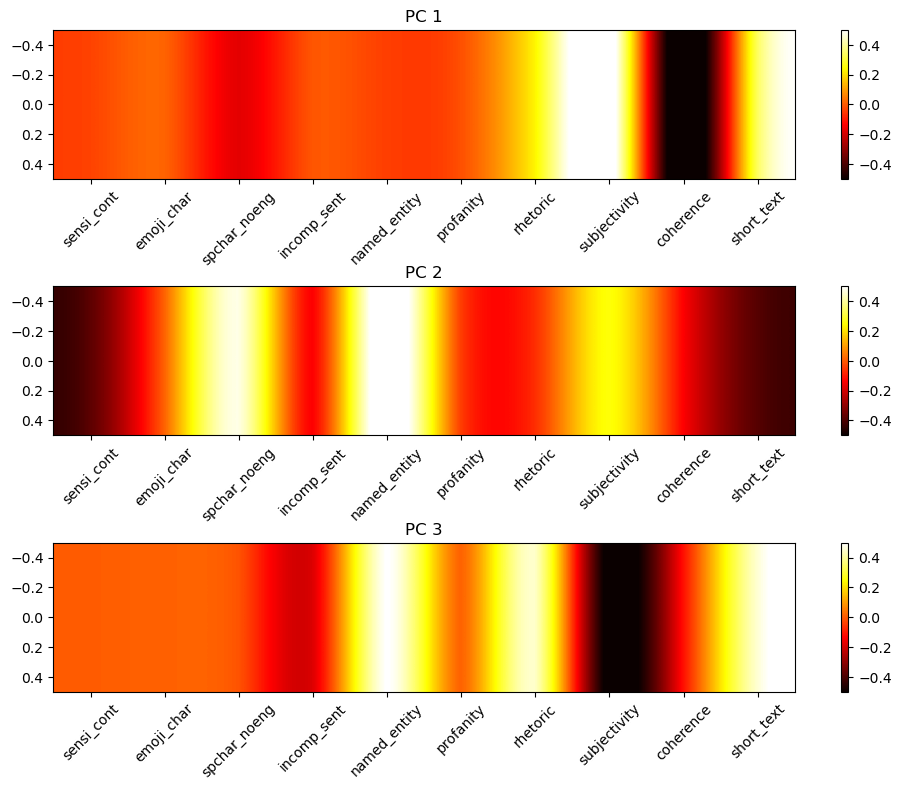

In [127]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, figsize=(10,9))
# fig.tight_layout(h_pad=2)

im=ax1.imshow(np.transpose(pca4_np1),vmin=-0.5,vmax=0.5, aspect='auto',cmap=cm.hot,interpolation='spline16')
ax1.set_title('PC 1')
fig.colorbar(im, ax=ax1)
ax1.set_xticks(np.arange(0,10,1))
ax1.set_xticklabels(feature_names,rotation=45)

im2=ax2.imshow(np.transpose(pca4_np2),vmin=-0.5,vmax=0.5, aspect='auto',cmap=cm.hot,interpolation='spline16')
ax2.set_title('PC 2')
fig.colorbar(im2, ax=ax2)
ax2.set_xticks(np.arange(0,10,1))
ax2.set_xticklabels(feature_names,rotation=45)

im3=ax3.imshow(np.transpose(pca4_np3),vmin=-0.5,vmax=0.5, aspect='auto',cmap=cm.hot,interpolation='spline16')
ax3.set_title('PC 3')
fig.colorbar(im3, ax=ax3)
ax3.set_xticks(np.arange(0,10,1))
ax3.set_xticklabels(feature_names,rotation=45)
fig.tight_layout()
plt.subplots_adjust(top=0.85)

In [128]:
type1.describe()

,id,pred_probability,sensi_cont,emoji_char,spchar_noeng,incomp_sent,named_entity,profanity,rhetoric,subjectivity,coherence,short_text,type1,type2
count,29.000000,29.000000,29.000000,29.0,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.0,29.0
mean,2174.172414,0.856142,0.206897,0.0,0.448276,0.034483,0.275862,0.137931,0.172414,0.241379,0.965517,0.413793,1.0,0.0
std,1265.658667,0.158744,0.412251,0.0,0.506120,0.185695,0.454859,0.350931,0.384426,0.435494,0.185695,0.501230,0.0,0.0
min,123.000000,0.513766,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0
25%,1291.000000,0.766291,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0,0.0
50%,2407.000000,0.908998,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0,0.0
75%,3203.000000,0.988307,0.000000,0.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.0,0.0
max,3995.000000,0.999803,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,0.0


In [129]:
type2.describe()

,id,pred_probability,sensi_cont,emoji_char,spchar_noeng,incomp_sent,named_entity,profanity,rhetoric,subjectivity,coherence,short_text,type1,type2
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.0,124.0
mean,2118.459677,0.711335,0.185484,0.016129,0.217742,0.120968,0.274194,0.040323,0.185484,0.346774,0.677419,0.758065,0.0,1.0
std,1198.790755,0.146176,0.390266,0.126483,0.414385,0.327413,0.447917,0.197513,0.390266,0.477874,0.469360,0.429993,0.0,0.0
min,4.000000,0.502060,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0
25%,1056.750000,0.583501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.0
50%,2202.500000,0.693137,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,1.0
75%,3138.250000,0.827269,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.0,1.0
max,3954.000000,0.991980,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.0


Getting the full misclassified dataset

In [3]:
full_missclassified = pd.read_csv("data/full_misclassified.csv")
full_missclassified

,Unnamed: 0,question,responses,actual_label,pred_label,pred_probability
0,0,"Why is every book I hear about a "" NY Times # ...","Basically there are many categories of "" Best ...",Real,Real,0.999831
1,1,"Why is every book I hear about a "" NY Times # ...","If you 're hearing about it , it 's because it...",Real,Real,0.998843
2,2,"Why is every book I hear about a "" NY Times # ...","One reason is lots of catagories . However , h...",Real,Real,0.549099
3,3,"Why is every book I hear about a "" NY Times # ...","One reason is lots of catagories . However , h...",Fake,Fake,0.999813
4,4,"If salt is so bad for cars , why do we use it ...",salt is good for not dying in car crashes and ...,Real,Fake,0.621937
...,...,...,...,...,...,...
85444,85444,Can Acutret be given to a child for treatment ...,Although it is difficult to comment whether Ac...,Fake,Fake,0.999826
85445,85445,Are BP of 119/65 and pulse of 35 causes for co...,Welcome and thank you for asking on HCM! I hav...,Real,Real,0.999396
85446,85446,Are BP of 119/65 and pulse of 35 causes for co...,Welcome and thank you for asking on HCM! I hav...,Fake,Fake,0.998882
85447,85447,Suggest treatment for back pain after walking ...,"Hi,Having this type of back pain at this age i...",Real,Real,0.998530


In [19]:
full_mis = full_missclassified.loc[full_missclassified['actual_label']!=full_missclassified['pred_label']]
full_mis.shape

(4392, 6)

In [47]:
4392/85449

0.05139908015307376

In [35]:
full = pd.merge(full_mis,anno,on=['question','responses','pred_label','actual_label'],how='outer')
full.drop(columns = ['pred_probability_y',"id",'short_text'],inplace=True)
full.rename({"pred_probability_x":"pred_probability",'Unnamed: 0':"id"}, axis = 1, inplace=True)
full

,id,question,responses,actual_label,pred_label,pred_probability,sensi_cont,emoji_char,spchar_noeng,incomp_sent,named_entity,profanity,rhetoric,subjectivity,coherence,type1,type2
0,4,"If salt is so bad for cars , why do we use it ...",salt is good for not dying in car crashes and ...,Real,Fake,0.621937,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,13,Why has nobody assassinated Kim Jong - un He i...,It would n't really do any good . It 's not li...,Real,Fake,0.778923,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,70,What will happen to the United States economy ...,You 're starting from a false assumption . The...,Real,Fake,0.595901,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,114,Is it true that glands in the breast that have...,Not true . Had a grandmother die of breast can...,Real,Fake,0.563964,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
4,123,How come I have to pay for Foxtel and get ads ...,Foxtel is an overpriced service . There 's a r...,Fake,Real,0.662721,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4387,85319,What causes pain in the flank region?I have du...,"Hi,This may be caused by tiny urinary / renal ...",Fake,Real,0.840085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4388,85322,Q. Will anxiety and depression get worse if I ...,Hello. I understand your concern regarding get...,Real,Fake,0.995951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4389,85364,Q. I have tooth pain with swollen gums for the...,"Hello. I suggest some medicines, but please st...",Real,Fake,0.500587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4390,85408,Q. What are those tiny fluid-filled blisters o...,Hello. I had gone through all the details post...,Fake,Real,0.968405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
full['type1'] = np.where(((full['actual_label']=='Fake')&(full['pred_label'] == "Real")),1,0)
full['type2'] = np.where(((full['actual_label']=='Real')&(full['pred_label'] == "Fake")),1,0)

In [44]:
def get_tokens(col):
     col_token = nltk.word_tokenize(col)
     return len(col_token)
full['short_text'] = full['responses'].apply(get_tokens)
full['short_text'] = np.where(full['short_text']<=250,1,0)

In [50]:
full.to_csv("data/misclassified.csv")

In [51]:
sample = full.sample(n=500,random_state=35)
sample.to_csv("data/sample_misclassified.csv")